# Introduction

A _decision tree_ is a nonparametric ml model that illustrates all the possible decision alternatives and the corresponding outcomes using a tree like decision making process.

Despite their simplicity, they are powerful and at one point the most popular machine learning model. This is partially because they have an underlying clarity and it is very easy to communicate it the ideas on an external level. For this reason, decision trees are known as whitebox models. Under the hood however, there is a lot of hidden complexity - and we will explore those details here. You can almost already guess what it is or what it does. Another huge benefit of is just how little data preparation is required. In particular preprocessing just as feature scaling or centering (standard scaling) is needed before hand. In addition DT's work both in regression and classification use cases.

Because decision trees make few assumptions about the model and are nonparametric (they dont have fit to an outlier linear model for example), they tend to closely outline the data and overfit if left unregularized or unconstrained. This the largest problem with lone decision tree, so they are often combined in a model ensemble like random forests.


## Anatomy

* A _internal node_ represents feature, for example weather. 
* A _branch_ is the choices of an internal node, which could be sunny, rainy, or cloudy for example.
* The _leaf_ nodes are the final outcomes, or the class specification. For instance, whether or not a group of two people played tennis.
* A _path_ represents the one instance of a decision making process.


![](../../../assets/tree_based_algorithms/sample_decision_tree.png)


## Construction


### Intuition
* By nature, decision trees are pretty simple to understand, but the real challenging is being to construct the most optimal configuration of the tree that leads to the most optimal results.
* Intuitively we can see that by starting with the most informative features, because these features will lead to a decision most quickly. In general, the simpler the tree is obtained the fewest number of splits, the more coherent it is to reality. 
* A good splits implies that most information was deduced from a split. For example, deducing the entire population on earth whether on gender might be a better split based on something else such as whether their favorite color is blue. This naturally produces a more coherent story in terms of how natural decisions are made. They begin from the most general (deducing a lot of information), to the more specific (fewer information).

    
### What can a Decision Tree Represent?

* Suppose our goal was to classify the following


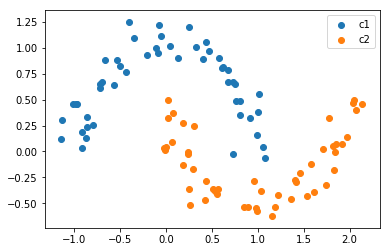

In [1]:
%matplotlib inline
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt


X, y = make_moons(100, noise=.1)
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], label='c1')
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], label='c2')
plt.legend()

Because a decision threshold must threshold on some number, it can only form _parallel axis frontiers_ - meaning that only horizontal or vertical lines can be made as a criteria for a decision. The decision boundaries are always going to be orthogonal to one another. This means that with many splits down the tree, we can actually approximate what is a diagonal line and more a "linear" line. 

![](../../../assets/tree_based_algorithms/representation_ex2.png)

This is good in the sense that we are even allowed to make a decision boundary in such a way. But it is also not good in the sense that a simplier linear model would do the trick in a much more simplified and regularized way. This also means that decisions trees are super sensative to data rotations. 


**To Demonstrate**

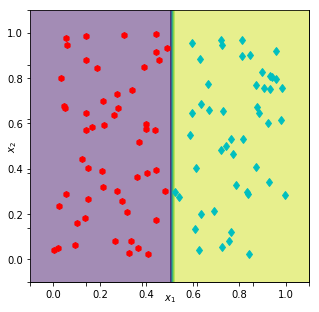

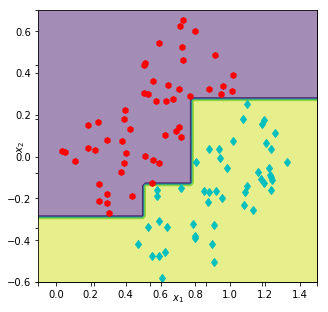

In [14]:
import numpy as np
from mltoolbox.draw.classification import plot_2d_decision_boundary
from sklearn.tree import DecisionTreeClassifier

# X: random cordinates between 0 and 1
# y: classify right half as class 1, remainder as class 0
X = np.random.rand(100, 2) 
y = (X[:, 0] > .5).astype(int)

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_s, tree_clf_sr = DecisionTreeClassifier(), DecisionTreeClassifier()
tree_clf_s.fit(X, y)
tree_clf_sr.fit(Xr, y)

plot_2d_decision_boundary([tree_clf_s], X, y, (-.1, 1.1), (-.1, 1.1), 100, 100, fig_size=(5, 5), contour=True)
plot_2d_decision_boundary([tree_clf_sr], Xr, y, (-.1, 1.5), (-.6, .7), 100, 100, fig_size=(5, 5), contour=True)


* A decision tree can also classify any boolean function, or even more generally, any discrete function. How achieve that is a different story.

### Thinking About the Algorithm

* Every time we split on an internal node, the remaining data also splits between the attributes or choices of that internal node. The data is split depending on the criteria of the internal node. This process is repeated per internal node, and the data associated with that internal node.

**Scoring**

* Every time a decision is made, the criteria for the data either fall into one camp or the other. This mean, we can only decrease or maintain the same level of error the further down the tree we go. In the case that the same level of error is maintained per level, then that is the worst we could do (depending on how you define the metric for error).
* The selection of what internal node is split it will be dependent on a score. We will dive into more detail on the score metric.

**Option 1: Lowest Error**
* As a measure of score consider the following idea: if you had the choice of selecting a single internal node to make the final classification, what would it be?
    * Naturally, we want to the internal node to split maximizes performance on classification. So if there exists a feature (or boundary) that maximizes the number of training examples between to classes, that this would be the most optimal choice. So one option for a scoring criteria is to greedily select the feature that minimizes error.
    * It is important to note that this error is defined by number of errors made if just classified on the current subset of data.
* Due to the nature of this greedy algorithm (continuous selected on the basis of lowest error), there is the possibility that even those minimum error was maintained earlier on, there is the possibility that it would have lead to inevitably having to deal with a lot more error later down the line. This can be shown in a nontrivial parity function example.
* Finding the most optimal decision tree that is more consistent with the data is actually an np-complete problem, and so when checking all tree configurations is out the question (there are $n^m$ tree configurations given a m-dimensional (or feature) dataset with n different values per each dimension), it is necessary to rely on some other heuristic.

#### A Short Digression into Information Theory

* Our goal here is to introduce another evaluation measure which is known as information gain, or mutual information.

**Surprise**

* Consider the following Bernoulli distribution of a coin flip:

| P(V=0) | P(V=1) |
|--------|--------|
|0       |1       |

* Knowing this distribution in advance, how can we measure how surprise someone is given a coin flip?
    * Obtaining 0 = infinite surprise
    * Obtaining 1 = 0 surprise
    
| P(V=0) | P(V=1) |
|--------|--------|
|.2      |.8      |


$$\text{surprise}(v) = -log(P(V=v))$$

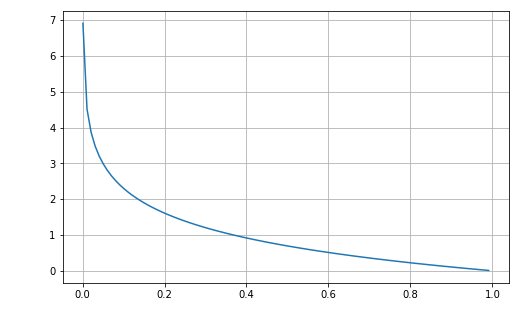

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mltoolbox.draw.math import plt_2d_functions


ax = plt_2d_functions([lambda x: -np.log(x)], x=np.arange(0.001, 1, .01), 
                      title='surprise(x)=-log(x)', xlabel='x (probability)', 
                      ylabel='y (surprise)', fig_size=(8, 5))
plt.show()

* This equation satisfied the criteria we discussed with 0 and 1 and is well defined within the bounds of the domain $0 \leq v \leq 1$. Additionally, it contains a desired exponentially property of gradually losing surprise the larger the $v$ and vise-versa. In other words, emotional surprise does no behave linearly (otherwise people would not become as excited winning the lottery).And finally, it has the desired diagonal symmetric for fairness (it goes both ways). 

**Entropy**

* Entropy is the probabilistic measure of uncertainty, and is defined as follows.

$$ H(V) = -\sum_{i=0}^n P(H=v)\log_2(P(H=v)) $$

* Where V is the random variable of an event
* n is the number of possible events

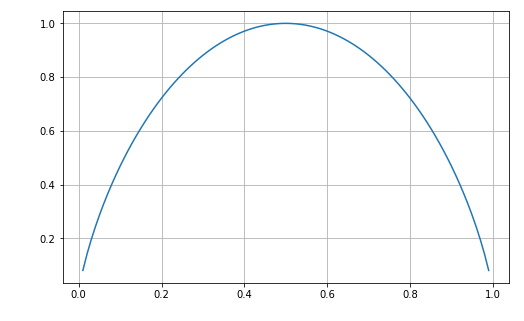

In [4]:
ax = plt_2d_functions([lambda x: -(x*np.log2(x)+(1-x)*np.log2(1-x))], x=np.arange(0.01, 1, .01), 
                      title='H(x)=-(x*log2(x)+(1-x)*log2(1-x))', xlabel='x (probability)', 
                      ylabel='H (entropy)', fig_size=(8, 5))
plt.show()



* Note that the example above is the graph of $-(x*\log_2(x)+(1-x)*\log_2(1-x))$, which is a less generalized formulation of the equation above. It relates to the binary case of two classifications (Bernoulli), which relative to the coin flip example we were talking about. Notice that the sum of events (x+(1-x)) are 1. This is a requirement of any random variable.
* Where as the previous question measured just a single instance of a surprise, entropy is nothing more than the average surprise. Going back to the example with P(V=0)=0 and P(V=1)=1, on average there would be zero surprise with both instances because in reality if that were the case, then there could only every be one exact outcome per event (and that is v=1). Using the context of average surprise makes sense because in general the more information that is known about a system, the less surprised we are on average.
* The equation satisfies the same properties as before in that 1) When either P(v=0) or P(v=1), then expectation is no surprise at all.
* The second question we have to answer is why surprise is multiplied by P(X=x). To understand this, we must first understand expectation. In statistics we defined expectation (or the average) of an event as $E[x] = \sum_{i=0}^n x_i P(x_i)$. For example, if we rolled a fair die, then the expectation or average number we would expect in this scenario would be $\frac{1}{6}+\frac{2}{6}+\frac{3}{6}+\frac{4}{6}+\frac{5}{6}+\frac{6}{6} 3.5$. The same idea is applied here. We are iterate through all possible events (2 in this case) and multiplying each event by the respective probability. If you think about it, this is just a more concise way of taking the average $\frac{x_1 + x_1 \dots x_n}{n}$, when each event is not necessarily _uniform_.
* When we have a fair coin, entropy is maximized. We can show why this is the case using contradiction. Consider the case when a coin is not fair $P(V \neq .5)$. In this case, were is will always be degree of favorability on one side of the coin. Therefore, the extent to which we are surprised will be slightly lower because we know more information about the coin that benefits higher predictability.

$$\text{Gini Impurity(K)} = 1 - \sum_{k=1}^K f_k^2$$

* There is another curve call the _gini coefficient_, which is very similar to the one we see above. It's performance therefore tends to be the same because it carries the same shape as entropy. K is the number of classes, and $0 \geq f_k \geq 1$, is that fraction of class $k$ taken up by the dataset. For example, if head and tails are the two classes that take up equal proportions in the training data, then the gini impurity would be $1-(.5^2+.5^2) = .5$.


**Mutual Information**

$$I[A;B] = H(A) - H(A|B)$$
$$I[A;B] = H(A) - \sum_{b} P(H=b)H[A|B=b]$$

* Reduction in uncertainty = information gain = entropy decrease
* The mutual information between two variables is the reduction in entropy in one of the variables you get from knowing the other. In other words, mutual information is the difference in entropy of $A$ and $A$ when $A$ knows $B$. Intuitively, conditioning on $b$ is just subsetting the data to instances of b. 
* Information gain is the reduction in certainty from before and after a split.
* So to compute information gain, the information we need to known is the entropy of class $A$ before we split on the attribute of $b$, $H(A)$, and the entropy of $A$ after knowing $b$. To compute the entropy of $A$ after knowing $B$, take the average (expectation) entropy of $A$ when subsetting on each of the attributes or branches of $b$.
* In the context of a decision tree, what we are interested in is the mutual information gained (the reduction in entropy) of a particular class, when knowing the value of a particular attribute. For example, how much entropy is lost in knowing that a couple will play tennis given that is it sunny outside?
* This equation satisfies similar edge cases from before. In particular when $H(A|B) = H(A)$, this implies knowing $B$ did absolutely nothing in terms of reducing the entropy. For example, whether or not your house is pink, red, or yellow will not influence your decision in playing tennis. On the other end, when $-H(A|B) = H(A)$, then we have an instance of maximum information gain. The attribute and value in this case would have maximally partitioned the class.
* The attribute that has the most information gain is the one that is we will decide to split on.
* Another way to think about it is when information gain is maximized, entropy loss is also maximized, and therefore the uncertainty about a particular class is minimized.
* Since $H(A)$ is usually omitted from the implementation because if you think about its construction, in the process of subsetting the data from node to node, if you in the end your characterization metrics are based off the subset this is the parent node, you are by design applying that conditional.


## Issues with Representation

* How can be incorporate continue values? This is an since in a multi-way split setting of branches, it would lead to an infinite number of splits.
    * We can produce ranges. e.g. (0-10), (11-20), etc.
    * Threshold based on relative quantity. e.g. >= 75% or < 75%
    * The decision on which range to split on can be made by checking every threshold and then splitting based off mutual information (discussed below).
* What about the case with zip codes that are discreet and would require the split on possibly thousands of values? (This may cause overfitting as well). A couple of options here include:
    * Grouping or subsetting into two disjoint subsets.
    * Splitting on each observed value of the feature (one vs all).
    * Adding a maximum depth, or minimum size constraint on the data for each node.
* One important thing to keep in mind is that if we have an attribute the effectively acts like a key in the schema, and we forget to move that key, then we would obtain 100% classification score. This is because would be able to just split on this key and uniquely identify the class from that key. This is not entirely obvious because the "key" can behave just partially as a key. Zip codes for example, could be somewhat unique and if we split on this attribute our classification would be very high - but it would still be an obvious case of over fitting. At the same time, just because an attribute has high classification accuracy, does not mean that it is overfitting.

###  Attributes with Many Values
* Naturally the move values an attribute has, the more information is has in terms of telling you what class belongs within each of the attributes. Zip codes for example, can actually be a good indicator of buying a yaut without overfitting to the data in the process. 
* So what we are really interested is the extra information about a class that is gained from splitting on an attribute, as opposed to the information that is unavoidably gained by of the merit of the attribute on its own.

$$\text{Gain Ratio(S,A)} = \frac{\text{Gain(S, A)}}{\text{Split Information(S, A)}}$$
$$\text{Split Information(S, A)} = - \sum_{i=1}^c \frac{|S_i|}{S} log_2 \frac{S_i}{S} $$

* $\text{Gain(S, A)}$ is the information gained by splitting class S on attribute A
* $\text{Split Information(S, A)}$ is the attribute of the attribute on its own.
* We can see that the more attributes we have in a class, the larger the dominator gets, which means the smaller the Gain Ratio. This gives the burden of an attribute of having to level predictability a class, than just having larger values.
    * For example, it would make no different if there the same number of people in each zipcode and we just divided by the number of zipcodes. But in the case the there a population disparity, it would make better sense to split on just a few of the larger populations rather than the smaller ones.
    
### Unknown Attributes Values

* In practice not all data is available. For example, in click stream mining we have user click information about every user, but only for a small subset of users, we have their registration information which can include important features such as demographic profile.
* One solution is to impute the data in. This means making up a statistically coherent value for the missing value. Options:
    * The most common value for that attribute.
    * Assign the most common value of attribute among other example of the same class. For example, if we do not know what color of a car a user bought last, but in the end we know that they bought a car, we can assign the missing color of the user to the most common color of the known example who did end up buying a car. This works better than the previous example.
    * But we can do even better. Like in the previous example, instead of taking the most common value, simulate a target value based off the distribution of the target class. For example, if we knew in the previous example that the target buyers owned 80% of a white car, 10% of a green car, and 10% of a red car previously, then we can impute a value based on this distribution.
* Now suppose that we have our final decision tree. Suppose we were to classify in new test data row. Suppose the that as we routed this through through the decision tree, we fell upon a missing value in the data row itself. How then do we know what direction to within the decision tree?
    * The answer here is to trickle down on ALL of the branches. Then when we we reach the leafs, we will have a distribution of classification. At this point we can do a few things: 1) we can simplify classify the input as the most frequently occurring value (aka _voting_), or 2) simulate a class like before, which is a variant of the _voting_ technique.



## Over fitting

* If our decision tree misclassifies an observation, then it could over some other random attribute that we have no control over? For example, the the phone rang, and the person had to go. Or the person had a hangover from the night before, so he was not in mood for tennis. This is an example of what would be considered as random noise.
* In the same light, if every path in a trained decision tree meets only for a single training instance, we will end up over fitting to the data. In other words, sparse paths that do not generalize inevitably leads to a bad classifier in practice.
* It can possible be for example for a neural network to completely memorize the training set with enough neurons.


**Formal definition of Over fitting**

* There are two kinds of error: the error from training (the data we are limited in having, $e_t$) and the error of the distribution (the error from all the data in the world, $e_d$).
* We are over fitting to the data if from our current hypothesis $h$ there exists another hypothesis $h'$ such that $e_t(h) < e_t(h')$ but $e_d(h) > e_d(h')$. In another words, a there exists a hypothesis that while performs worst on the training dataset, it actually performs better in the real world. 
* $e_d$ is simulated with a test set in practice.

### Avoiding Over Fitting

* First train and build the decision tree using the complete training set.
* Set aside some data from the training set to prune the tree. Continue to prune the tree until some metric tells you to stop.
* This not might be a good option if we don't have much data because there is more typically more value associated with smaller quantities of data.
* One problem however with a lot of data is that it increases the odds of additional noise. This means that the decision tree may grow to a larger order of magnitude simply due to noise.
* Another option to avoid over fitting is to first allow the tree to gorw in an unconstrained manner, and then apply statistical tests like chi-squared to determine whether or not to stop. More specifically, we would be testing whether the class distribution we had  from before is significantly different the introduced class distribution as a result of adding the attribute. This is known as pre-pruning with a chi-squared test. To was later discovered the with post-pruning (which later became the norm) you can generally do a lot better. It can be shown that despite who class distributions being the same, and pre-pruning would conclude its assessment, that at later stages of the tree, this would turn out to be a good thing.
* When we don't have much data the recommend option is to change our evaluation metric (which we earlier defined as information gain. One heuristic we know is that the larger the tree gets, the greater chance we are over fitting to the data. Therefore we can use a heuristic such as the number of current nodes in the tree as an additional penalty to the evaluation metric to avoid overfitting. This is known as the "complexity penalty" that only "allows" a tree to continue to grow if the opposing metric (information gain) is enough to overshoot the complexity penalty.

Sklearn provides the following regularization parameters to constrain the model (and hecne terminate the recursive building operation).
* `max_depth`: The maximum depth of the tree as to limit it's size.
* `min_sample_split` or `min_weight_fraction_split`: To control the amount (or relative amount) of data per internal node.
* `max_features`: Limit the number of features that evaluated for splitting at each node.

#### Reduced Error Pruning

* Post prune (discussed earlier) is also known as _reduced error pruning_. The algorithm for it goes as follows:
    1. Split the data into training and validation set.
    2. Fit the tree to the training data.
    3. Evaluate the impact of the validation set on every node in the tree.
    4. Remove the node that most improves the validation set accuracy. If there is no improvement, the algorithm concludes.
    5. Otherwise repeat step 3.
    

#### Rule Post Pruning
1. Build the tree.
2. Convert or induce the tree into a set of rules.
3. Prune each rule independently from others.
4. Sort final rules for desired sequence of use.

##### Converting a Tree into a set of Rules
* A decision tree is nothing more than nested if statement. So a single rule within a decision tree is a root to leaf path. Therefore the set of all rules in a decision tree are encoded as the set of all the root to leaf paths. If there are $n$ leafs in a tree, then there are also $n$ rules.
* One advantage of flattening a tree into a set of rules is that now we have more options on what to prune. Within a tree for example, we have to begin from the bottom up because if we prune out an internal node we implicitly also prune out the entire subtree under neath it. The distinct difference between a tree and a set of rule is that one a single path can fire in a tree, where as more than one path can fire in a set of rules (when it a pruned of course).
    * A decision tree while faster (logarithmic classification speed), classifying on a set of rules tends to be more accurate.
* To illustrate how we can prune a set of rules, lets go through an example. Suppose we have the set of rules and our validation data. Now by observing a single rule, our goal is to remove path segments from that rule that optimizes classification. Objectively, we can look at each segment in this rule and observe if removing it increases performance on the validation set. If it does, then the segment can be removed and we have a shorter rule. This process can be iterator across each rule until improvement is no longer observed.
* Next an order needs to be applied on the rules because no all rules are made equal, and there are multiply valid rules that lead to different classifications. On option is to order the rules by the level of accuracy they achieve.
    * Then the process of classification would require an iteration through the ordered rules until the the first rule that fires (pull though the path) classifies the instance.
    * As a even more robust technique, we can have every rule that fires for the instance vote for the classification of an instance. The vote for a particular vote can be also weighed by the accuracy of the rule (or if it is ordered, the inverse index of the rule). In addition to the accuracy, what is often use is _coverage_, which measures how many examples the rule accounts for. For example, we two rules while both 100% accurate can account for a different subset of training examples. The rule that accounts for more training examples ideally should carry a larger weight because in generalize to the data more.

## Implementation

There are two distinct ways to implement a decision tree classifier. Sklearn implements a stochastic `CART` which always splits using binary trees. Due to the random nature of the stochastic process, this means that the actual model would vary from run-to-run without a set random seed.

There are also algorithms such as ID3 that can produce trees with more than two children. 

## Time Complexity

The CART algorithm of decision trees are constructed in $O(n \cdot m log_2(m))$ time where $m$ is the scale of the data set and $n$ is the number of features. This is because the data is partitioned and decreases by roughly half every time per node construction and on a per node basis $n$ features are compared to $m$ samples.


**????** Double check this idea:

Note that $n$ and $m$ here will decrease deeper into the tree, because previous features get exhausted and more data gets partitioned off.